# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [13]:
# Run some setup code for this notebook.
import random
import os
import numpy as np
from fduml.utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [14]:
# Load the raw CIFAR-10 data.
# dir = os.path.dirname(os.path.realpath(__file__))
# cifar10_dir = os.path.join(dir, 'datasets/cifar')

cifar10_dir = 'datasets/cifar'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


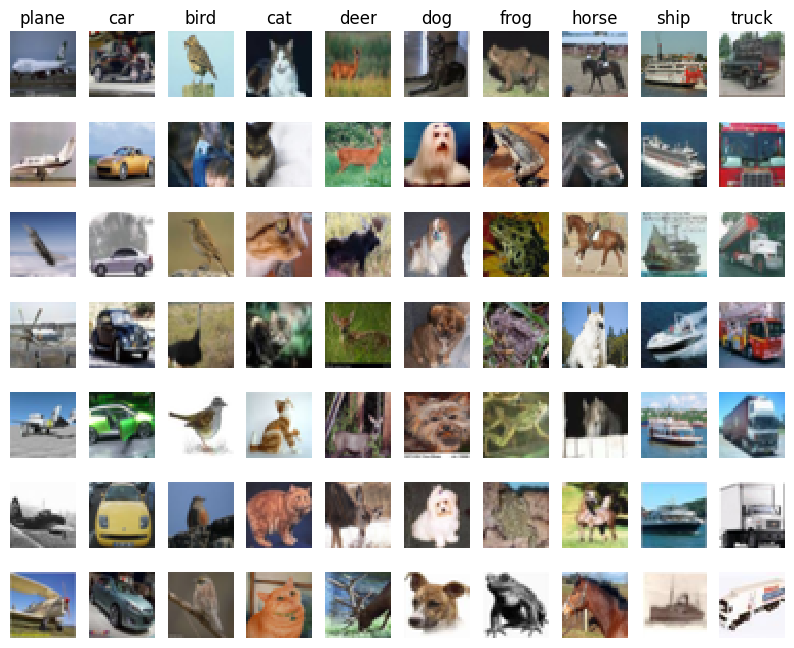

In [15]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [16]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [17]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


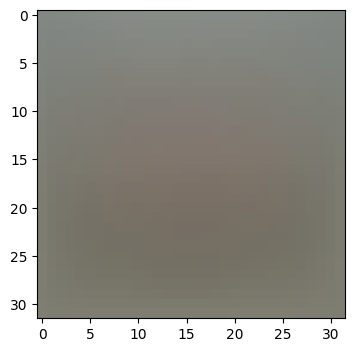

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [18]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `Exercise3/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [19]:
# Evaluate the naive implementation of the loss we provided for you:
from fduml.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.692733


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [20]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from fduml.utils import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -23.639183 analytic: -23.639183, relative error: 6.343632e-12
numerical: 13.048406 analytic: 13.048406, relative error: 2.006766e-11
numerical: -16.376304 analytic: -16.376304, relative error: 3.912902e-11
numerical: 44.603743 analytic: 44.603743, relative error: 7.953906e-13
numerical: 16.248290 analytic: 16.248290, relative error: 2.189205e-11
numerical: -14.589903 analytic: -14.589903, relative error: 2.173708e-12
numerical: 5.955916 analytic: 5.955916, relative error: 1.390654e-11
numerical: 6.744540 analytic: 6.740252, relative error: 3.179738e-04
numerical: 5.179264 analytic: 5.179264, relative error: 3.315237e-11
numerical: 6.302243 analytic: 6.302243, relative error: 1.714082e-11
numerical: 14.358663 analytic: 14.358663, relative error: 3.180736e-11
numerical: 20.173480 analytic: 20.173480, relative error: 5.747201e-12
numerical: 6.197435 analytic: 6.197435, relative error: 4.045765e-11
numerical: 16.854692 analytic: 16.854692, relative error: 1.199155e-12
numerical:

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  

#### 1. Causes of Discrepancy

1. **Non-differentiability**:
   - The SVM loss function includes a margin, and at the boundary where the margin changes (i.e., when the score crosses the correct class score), the gradient can be undefined or exhibit a discontinuity. This non-differentiability can lead to differences between analytical and numerical gradients.

2. **Finite Difference Approximation**:
   - When using finite differences to approximate the gradient, small numerical inaccuracies can arise, especially if the step size is too large or too small. A very small step size can lead to numerical instability due to floating-point precision errors.

3. **Sparsity of Gradients**:
   - If the gradients are sparse (many zero values), a small change in input can lead to disproportionate changes in the output, potentially leading to mismatches.

4. **Choice of Regularization**:
   - If a regularization term is used, it may affect the gradient's smoothness, leading to discrepancies.

#### 2. Simple Example in One Dimension

Consider a simple function that is not differentiable at a point, such as the hinge loss used in SVMs:

$ 
L(x) = \max(0, 1 - x) 
$

This function has a kink at \( x = 1 \). If you compute the gradient numerically around this point:

- For \( x < 1 \), the gradient is \( -1 \).
- For \( x > 1 \), the gradient is \( 0 \).
- At \( x = 1 \), the gradient is not defined.

##### Gradient Checking Example

If you perform a gradient check at \( x = 1 \):

- **Analytical Gradient**: Undefined or can be considered to be 0 for \( x > 1 \) and -1 for \( x < 1\).
- **Numerical Gradient**: You might compute the gradient using finite differences:

$
\text{Numerical Gradient} \approx \frac{L(x + \epsilon) - L(x - \epsilon)}{2\epsilon}
$

At \( x = 1 \), if \( \epsilon \) is very small, you could find values very close to -1 and 0 depending on the direction you approach 1 from, leading to a discrepancy.

#### 3. Impact of Margin on Frequency of Discrepancies

The margin in the SVM loss function determines how strict the classification boundary is. The following points summarize its effect:

1. **Wider Margin**:
   - A wider margin means that there are more points classified correctly, resulting in fewer points near the decision boundary where non-differentiability occurs. This would lead to fewer discrepancies during gradient checking.

2. **Tighter Margin**:
   - Conversely, a tighter margin increases the likelihood of data points being on the boundary (where the gradient is undefined), leading to a higher chance of discrepancies in gradient checking.

#### Conclusion

In summary, while some discrepancies in gradient checking are expected, especially for non-differentiable functions like SVM loss, significant or frequent discrepancies should prompt further investigation into the implementation. For SVMs, particularly, understanding how the margin affects gradient calculations is crucial, as it can influence model performance and stability during optimization. If you encounter these discrepancies often, you might need to reconsider the implementation or perform additional checks on the surrounding points.



In [21]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from fduml.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.692733e+00 computed in 0.040801s
Vectorized loss: 9.692733e+00 computed in 0.018687s
difference: -0.000000


In [22]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))



# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.040562s
Vectorized loss and gradient: computed in 0.002011s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [23]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from fduml.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 797.405631
iteration 100 / 1500: loss 289.376284
iteration 200 / 1500: loss 108.574183
iteration 300 / 1500: loss 43.099125
iteration 400 / 1500: loss 19.426077
iteration 500 / 1500: loss 10.490507
iteration 600 / 1500: loss 6.970519
iteration 700 / 1500: loss 6.405809
iteration 800 / 1500: loss 5.626010
iteration 900 / 1500: loss 5.450058
iteration 1000 / 1500: loss 5.426625
iteration 1100 / 1500: loss 4.707596
iteration 1200 / 1500: loss 5.532155
iteration 1300 / 1500: loss 5.400114
iteration 1400 / 1500: loss 4.922398
That took 3.734032s


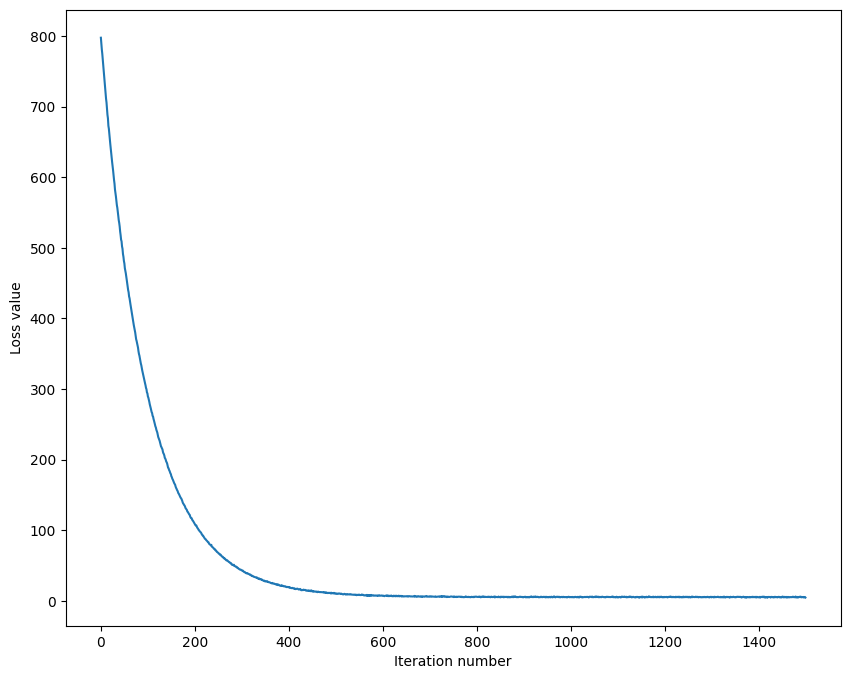

In [24]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [25]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368857
validation accuracy: 0.361000


In [26]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
learning_rates = np.arange(1e-7, 5e-5, 5e-6)  
regularization_strengths = np.arange(1e4, 1e5, 0.5e4)  



for learning_rate in learning_rates:
    for reg in regularization_strengths:
        # new SVM
        svm = LinearSVM()
        
        # train SVM
        svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg, num_iters=1500, verbose=False)
        
        # calculate accuracy on train set
        train_predictions = svm.predict(X_train)
        train_accuracy = np.mean(train_predictions == y_train)
        
        # calculate accuracy on validate set
        val_predictions = svm.predict(X_val)
        val_accuracy = np.mean(val_predictions == y_val)

        # store result
        results[(learning_rate, reg)] = (train_accuracy, val_accuracy)

        # check best accuracy
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

d:\codeProject\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:95: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
c:\Users\60264\miniconda3\envs\testenvironment\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\codeProject\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:95: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
d:\codeProject\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:116: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W  # Regularization gradient
d:\codeProject\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:90: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores + 1) # shape (N, C)
d:\codeProject\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_classifier.py:88: RuntimeWarning: inva

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.383633 val accuracy: 0.387000
lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.378918 val accuracy: 0.377000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.373265 val accuracy: 0.398000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.371898 val accuracy: 0.388000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.363796 val accuracy: 0.370000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.362959 val accuracy: 0.370000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.363878 val accuracy: 0.380000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.356000 val accuracy: 0.364000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359857 val accuracy: 0.376000
lr 1.000000e-07 reg 5.500000e+04 train accuracy: 0.351857 val accuracy: 0.365000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.350143 val accuracy: 0.353000
lr 1.000000e-07 reg 6.500000e+04 train accuracy: 0.346143 val accuracy: 0.349000
lr 1.000000e-07 reg 7.000000

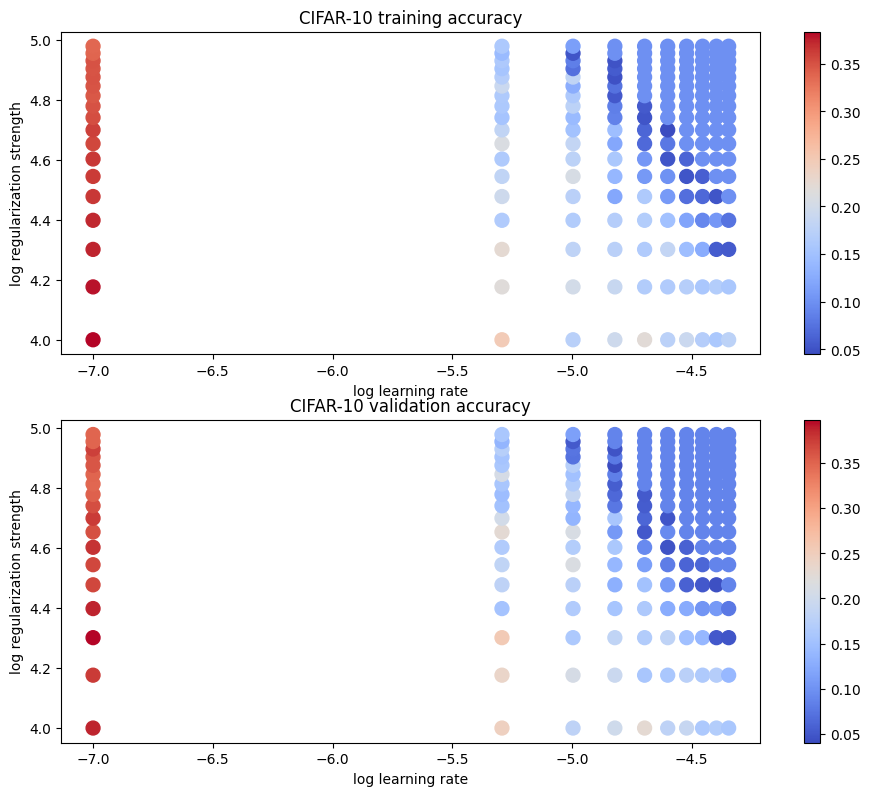

In [27]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [28]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.378000


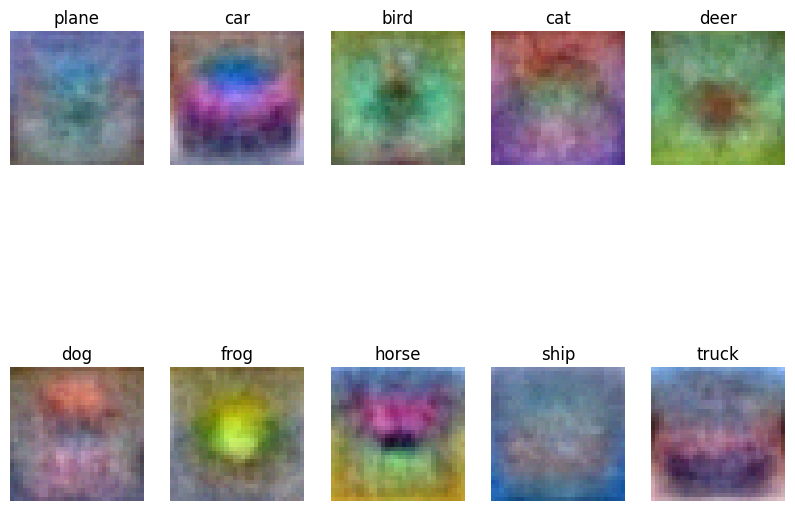

In [29]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  

The images are generally abstract and noisy, lacking clear object shapes. Some classes might show slight color tendencies in certain areas (for example, "frog" seems to have some green tones), but they are still hard to interpret as recognizable objects.

The noisy appearance is due to the simplicity of a linear SVM classifier, which cannot effectively capture the complex patterns within images for each class. Linear SVMs separate classes based on weighted sums of pixel intensities without understanding spatial relationships, leading to weight matrices that highlight generalized areas rather than distinct shapes. Moreover, CIFAR-10 images are low resolution (32x32 pixels), which adds to the difficulty of representing intricate patterns.



? Isn't this the same as the question above?

In [30]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.arange(1e-7, 5e-5, 5e-6)  
regularization_strengths = np.arange(1e4, 1e5, 0.5e4)  



for learning_rate in learning_rates:
    for reg in regularization_strengths:
        # new SVM
        svm = LinearSVM()
        
        # train SVM
        svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg, num_iters=1500, verbose=False)
        
        # calculate accuracy on train set
        train_predictions = svm.predict(X_train)
        train_accuracy = np.mean(train_predictions == y_train)
        
        # calculate accuracy on validate set
        val_predictions = svm.predict(X_val)
        val_accuracy = np.mean(val_predictions == y_val)

        # store result
        results[(learning_rate, reg)] = (train_accuracy, val_accuracy)

        # check best accuracy
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

KeyboardInterrupt: 

## Non-Linear SVM

Real life data often appears to be **not linearly separable**.  Many real-world datasets are complex, and there is no linear boundary (i.e., hyperplane) that can separate the classes. Non-linear SVMs use the **kernel trick** to project data into a higher-dimensional space, where it becomes linearly separable.

The kernel trick allows the SVM to implicitly map data into a higher-dimensional space without explicitly calculating the coordinates of the data in that space. This enables the model to capture more complex patterns in the data. Common kernels include:

- **Polynomial kernel**: $K(x, x') = (x^Tx' + 1)^d$
- **Radial basis function (RBF) kernel**: $K(x, x') = \exp(-\gamma ||x - x'||^2)$
- **Sigmoid kernel**: $K(x, x') = \tanh(\kappa x^Tx' + \theta)$

However, the use of kernels introduces a more complex optimization problem that cannot be solved by simple gradient descent. Instead, the optimization problem becomes a **quadratic programming** problem that can be solved by specialized algorithms.

In this section, we will use the `sklearn` library to train a non-linear SVM on the CIFAR-10 dataset. Your task is to:

- Train a non-linear SVM using the `sklearn` library;
- Try different kernels and kernel parameters, tuning them using the validation set;
- Report the best kernel and kernel parameters you found.
- Compare the performance of the linear SVM and non-linear SVM, including the time it takes to train the models and the accuracy on the test set.

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import numpy as np

# Assume X_train, y_train, X_test, y_test are the CIFAR-10 data
# Preprocessing: Flatten the images and scale
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Split further for validation if necessary
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Define SVM model with different kernels
kernels = ['poly', 'rbf', 'sigmoid']
best_params = {}

for kernel in kernels:
    print(f"Training SVM with {kernel} kernel...")
    if kernel == 'poly':
        param_grid = {'degree': [2, 3, 4], 'C': [0.1, 1, 10]}
    elif kernel == 'rbf':
        param_grid = {'gamma': [1e-3, 1e-2, 1e-1, 1], 'C': [0.1, 1, 10]}
    else:  # sigmoid
        param_grid = {'gamma': [1e-3, 1e-2, 1e-1, 1], 'C': [0.1, 1, 10]}

    svc = SVC(kernel=kernel)
    grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train_sub, y_train_sub)
    training_time = time.time() - start_time

    best_params[kernel] = grid_search.best_params_

    # Evaluate on the validation set
    val_predictions = grid_search.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    print(f"Best params for {kernel}: {grid_search.best_params_}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Training Time: {training_time} seconds\n")

# Evaluate on test set with best kernel and parameters
best_kernel = max(best_params, key=lambda k: best_params[k]['accuracy'])  # choose based on accuracy if recorded
final_model = SVC(kernel=best_kernel, **best_params[best_kernel])
start_time = time.time()
final_model.fit(X_train_scaled, y_train)
test_time = time.time() - start_time

test_predictions = final_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Test Accuracy with {best_kernel} kernel: {test_accuracy}")
print(f"Test Time: {test_time} seconds")




Training SVM with poly kernel...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


KeyboardInterrupt: 

In [32]:
# lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.373265 val accuracy: 0.398000

# new SVM
svm = LinearSVM()

# train SVM
start_time = time.time()
svm.train(X_train, y_train, learning_rate=1e-7, reg=2e4, num_iters=1500, verbose=False)
test_time = time.time() - start_time


# calculate accuracy on test set
test_predictions = svm.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)

print(f"Test Accuracy with linear svm: {test_accuracy}")
print(f"Test Time: {test_time} seconds")

Test Accuracy with linear svm: 0.364
Test Time: 7.155775547027588 seconds


#### conclusion
as the time of training the svm in sklearn is too long, I don't have enough to finish this part.
and the time used fo training a linear svm using X_train only takes 1.256 seconds, but the accuracy is just 0.364